# **CSCI323 group assignment (house price prediction)**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import os
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import MultiTaskLasso, MultiTaskLassoCV

In [2]:
# make everything 100% reproducible
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Make PyTorch deterministic
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Limit CPU threads used by numpy & sklearn
    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["MKL_NUM_THREADS"] = "1"

seed_everything(42)

In [3]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [4]:
'''
# load the dataset (on google colab)
df = pd.read_csv("/content/drive/MyDrive/CSCI323_grp_assignment/dataset/kc_house_data.csv")

# create raw version of dataset (for EDA purposes)
df_raw = df.copy()
'''

'\n# load the dataset (on google colab)\ndf = pd.read_csv("/content/drive/MyDrive/CSCI323_grp_assignment/dataset/kc_house_data.csv")\n\n# create raw version of dataset (for EDA purposes)\ndf_raw = df.copy()\n'

loading the dataset from github repo

In [5]:
url = "https://raw.githubusercontent.com/jplx03/house-price-prediction-stl-vs-mtl/main/dataset/kc_house_data.csv"
df = pd.read_csv(url)

# create raw version of dataset (for EDA purposes)
df_raw = df.copy()

## **Exploratory Data Analysis:**

In [6]:
# checking how many rows and columns the dataset has
nRow, nCol = df_raw.shape
print(f'There are {nRow} rows and {nCol} columns.')

There are 21613 rows and 21 columns.


In [7]:
# checking the stats of the dataset
df_raw.describe()

id         price      bedrooms     bathrooms   sqft_living  \
count  2.161300e+04  2.161300e+04  21613.000000  21613.000000  21613.000000   
mean   4.580302e+09  5.400881e+05      3.370842      2.114757   2079.899736   
std    2.876566e+09  3.671272e+05      0.930062      0.770163    918.440897   
min    1.000102e+06  7.500000e+04      0.000000      0.000000    290.000000   
25%    2.123049e+09  3.219500e+05      3.000000      1.750000   1427.000000   
50%    3.904930e+09  4.500000e+05      3.000000      2.250000   1910.000000   
75%    7.308900e+09  6.450000e+05      4.000000      2.500000   2550.000000   
max    9.900000e+09  7.700000e+06     33.000000      8.000000  13540.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  2.161300e+04  21613.000000  21613.000000  21613.000000  21613.000000   
mean   1.510697e+04      1.494309      0.007542      0.234303      3.409430   
std    4.142051e+04      0.539989      0.086517      0.766318      0.650743   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.040000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.618000e+03      1.500000      0.000000      0.000000      3.000000   
75%    1.068800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

              grade    sqft_above  sqft_basement      yr_built  yr_renovated  \
count  21613.000000  21613.000000   21613.000000  21613.000000  21613.000000   
mean       7.656873   1788.390691     291.509045   1971.005136     84.402258   
std        1.175459    828.090978     442.575043     29.373411    401.679240   
min        1.000000    290.000000       0.000000   1900.000000      0.000000   
25%        7.000000   1190.000000       0.000000   1951.000000      0.000000   
50%        7.000000   1560.000000       0.000000   1975.000000      0.000000   
75%        8.000000   2210.000000     560.000000   1997.000000      0.000000   
max       13.000000   9410.000000    4820.000000   2015.000000   2015.000000   

            zipcode           lat          long  sqft_living15     sqft_lot15  
count  21613.000000  21613.000000  21613.000000   21613.000000   21613.000000  
mean   98077.939805     47.560053   -122.213896    1986.552492   12768.455652  
std       53.505026      0.138564      0.140828     685.391304   27304.179631  
min    98001.000000     47.155900   -122.519000     399.000000     651.000000  
25%    98033.000000     47.471000   -122.328000    1490.000000    5100.000000  
50%    98065.000000     47.571800   -122.230000    1840.000000    7620.000000  
75%    98118.000000     47.678000   -122.125000    2360.000000   10083.000000  
max    98199.000000     47.777600   -121.315000    6210.000000  871200.000000

In [8]:
# checking first 5 rows of the dataset
df_raw.head(5)

id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

In [9]:
# check dataset info
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [10]:
# checking for missing values in each column
missing = df_raw.isnull().sum()
print(missing)

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [11]:
# checking how many zero values in each column
zero_counts = (df_raw == 0).sum()
print("Zero counts per column:")
print(zero_counts)

Zero counts per column:
id                   0
date                 0
price                0
bedrooms            13
bathrooms           10
sqft_living          0
sqft_lot             0
floors               0
waterfront       21450
view             19489
condition            0
grade                0
sqft_above           0
sqft_basement    13126
yr_built             0
yr_renovated     20699
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64


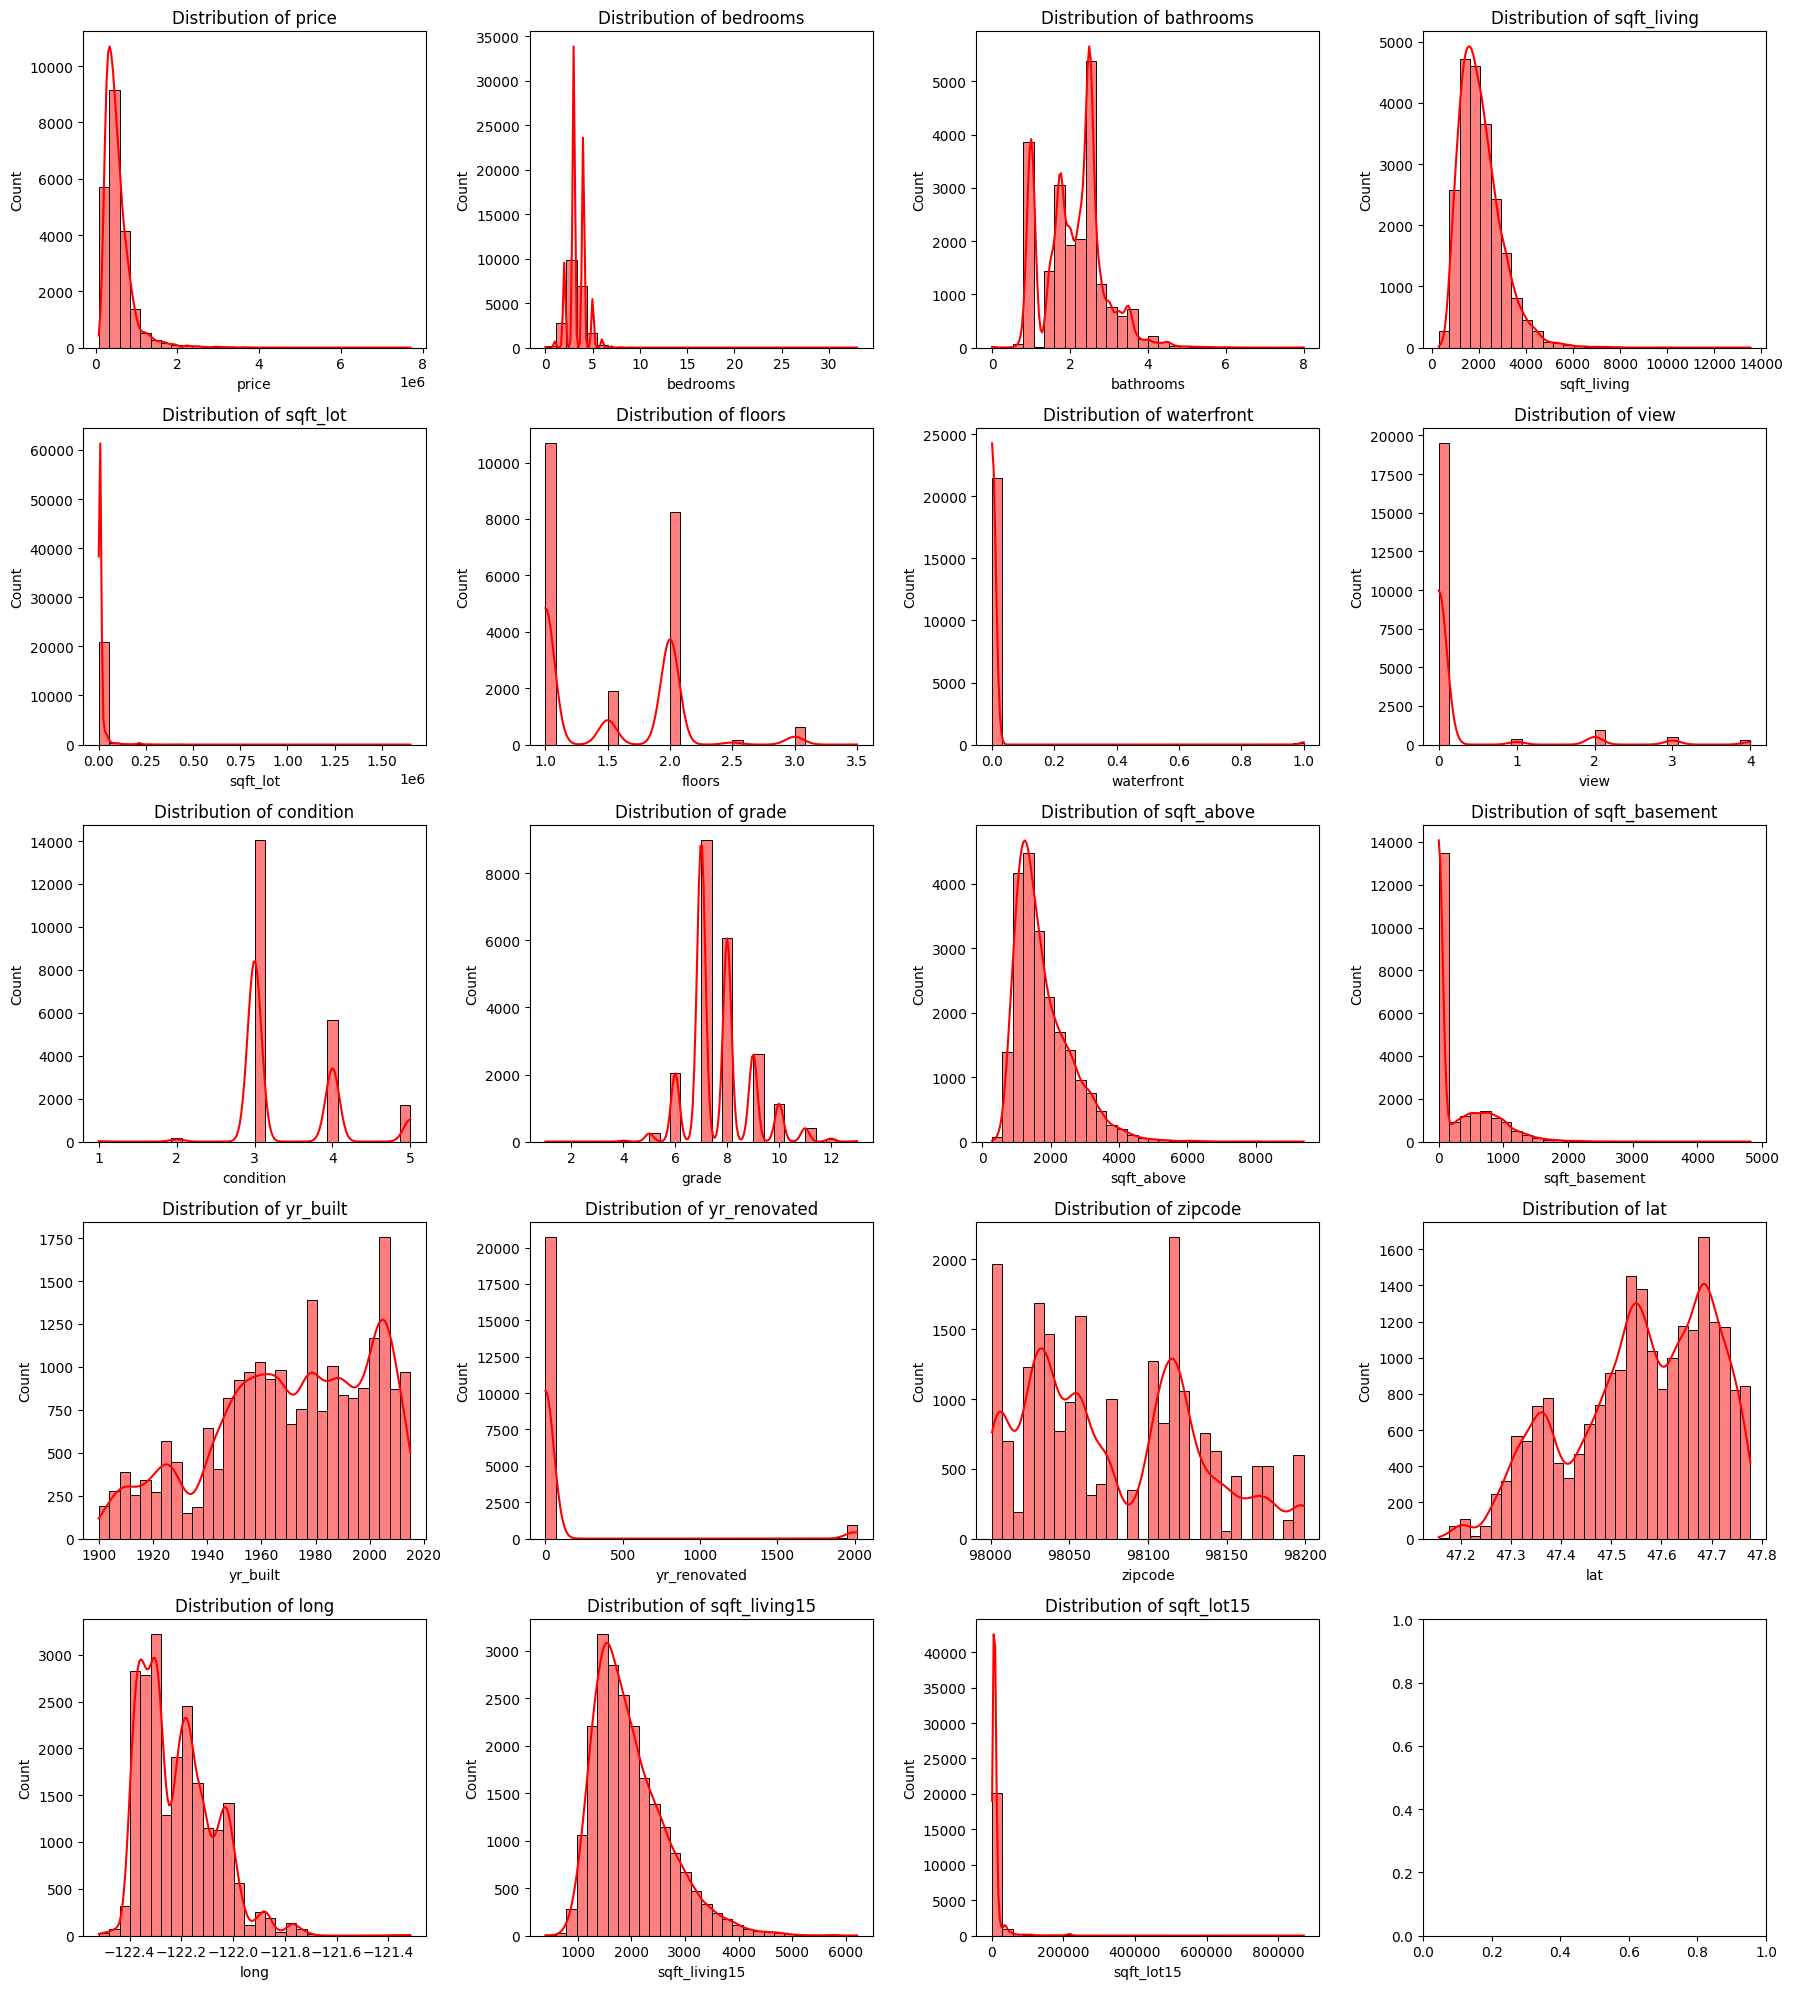

In [12]:
# plot histograms to visualise distribution of data
num_cols = df_raw.select_dtypes(include=['int64', 'float64']).columns
num_cols = [c for c in num_cols if c != 'id']  # exclude id

n_cols = 4
n_rows = int(np.ceil(len(num_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(df_raw[col], bins=30, kde=True, ax=axes[i], color='red')
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
plt.tight_layout()
plt.show()

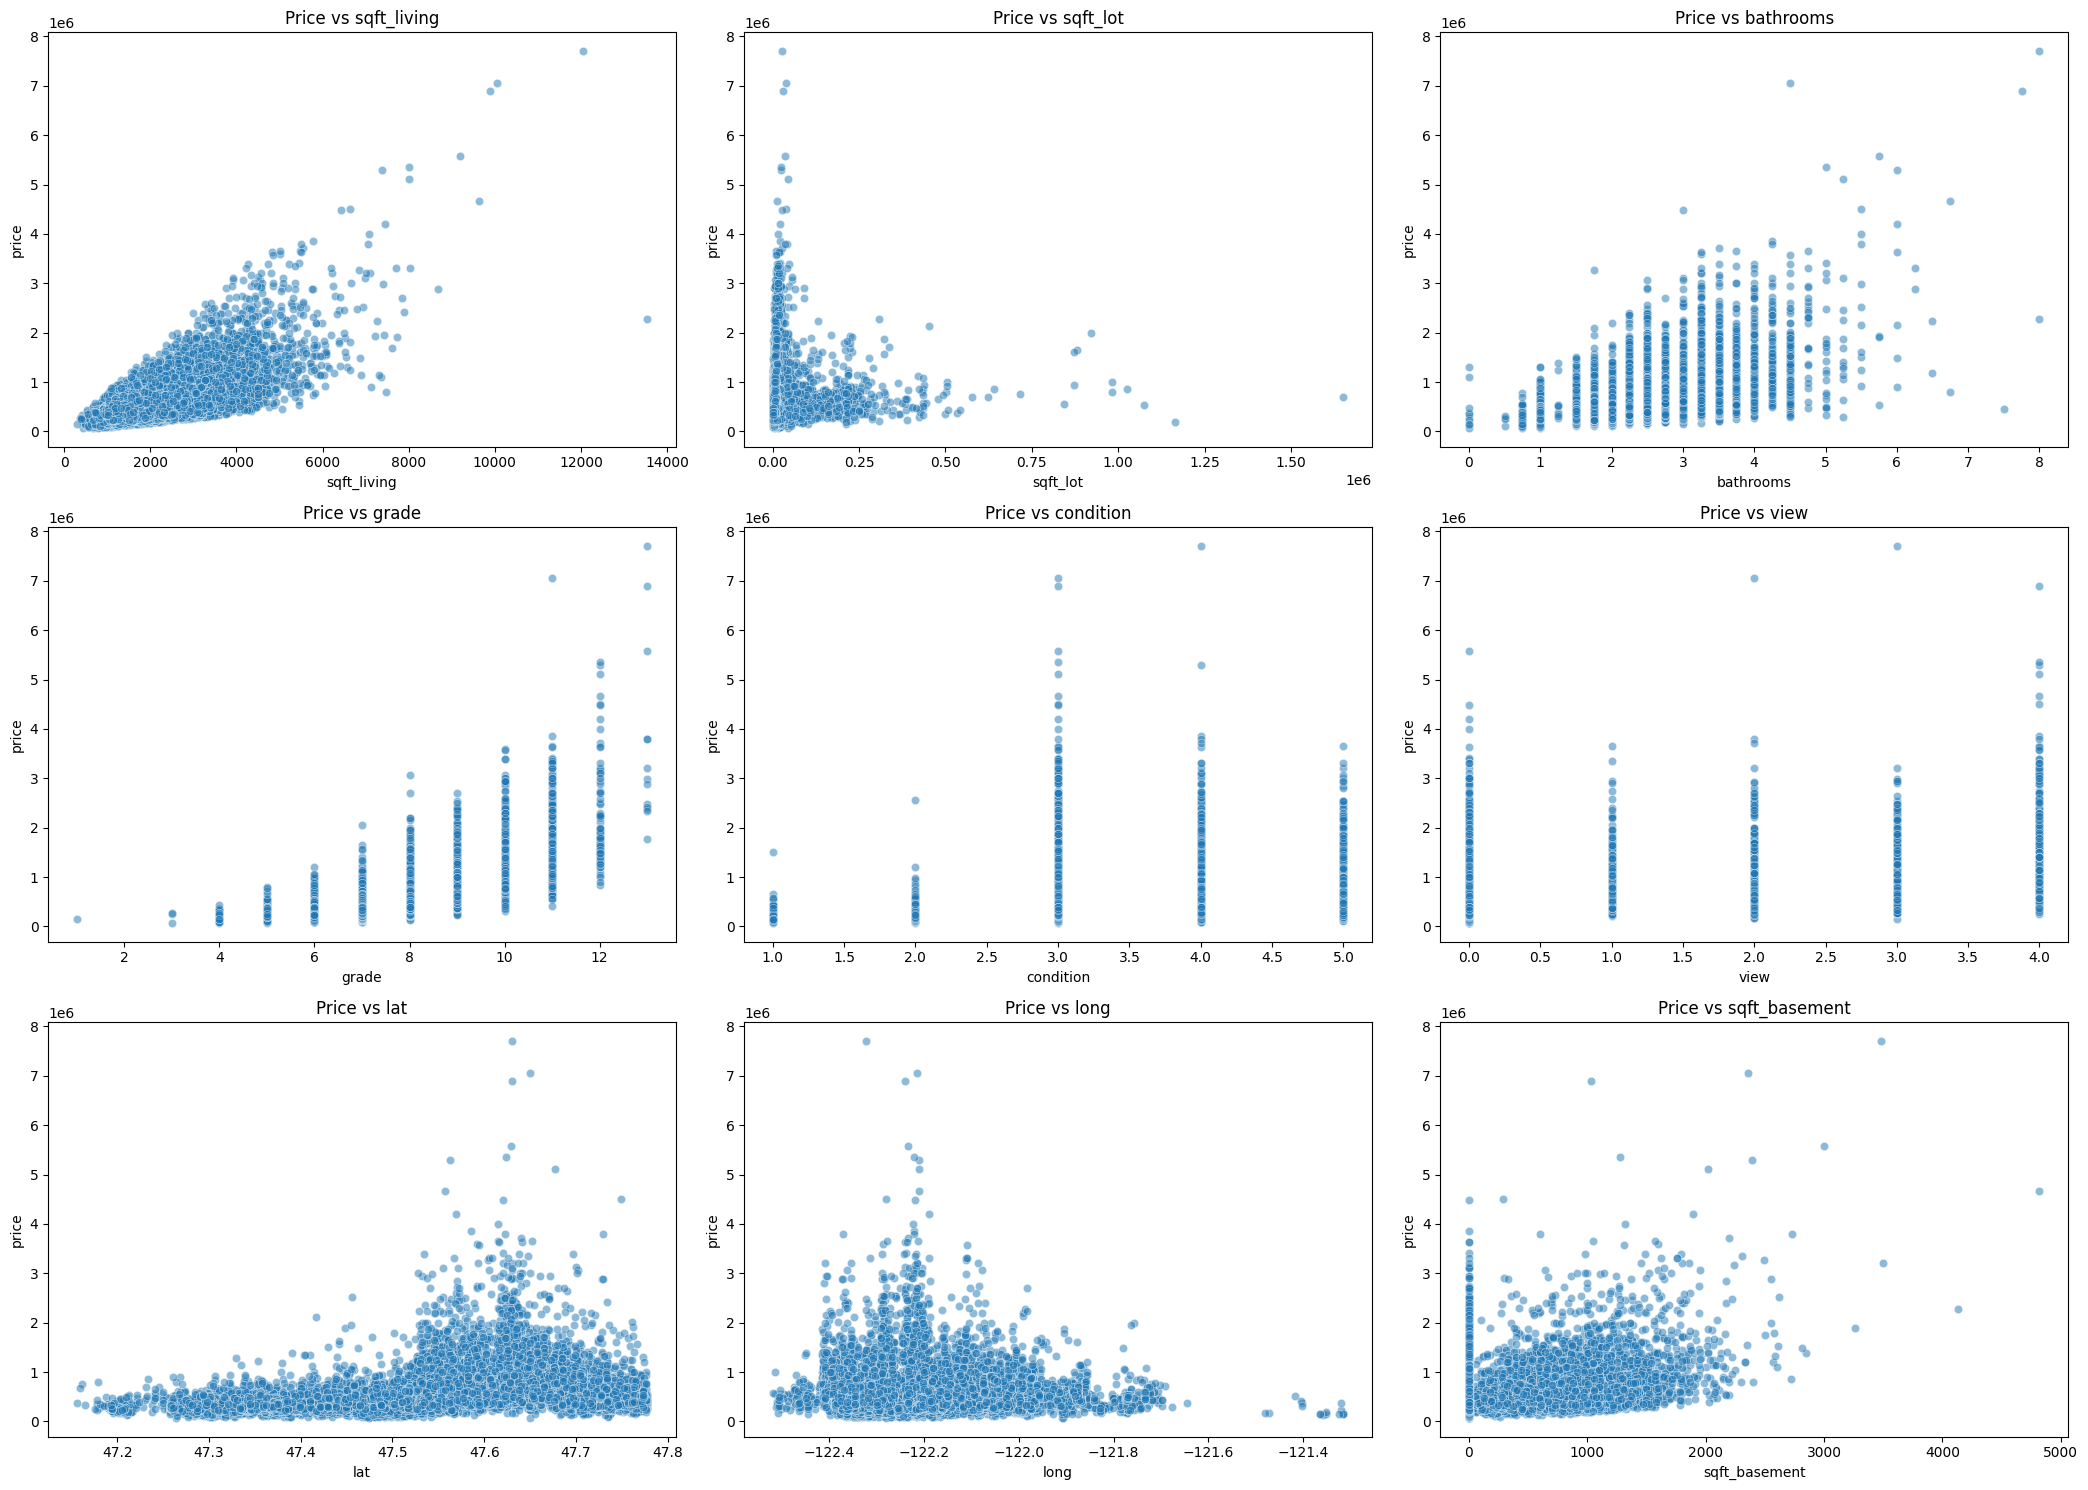

In [13]:
# scatter plots

key_features = ['sqft_living', 'sqft_lot', 'bathrooms', 'grade', 'condition', 'view', 'lat', 'long', 'sqft_basement']
plt.figure(figsize=(21, 15))
for i, feature in enumerate(key_features, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=df_raw, x=feature, y='price', alpha=0.5)
    plt.title(f"Price vs {feature}")
plt.tight_layout()
plt.show()

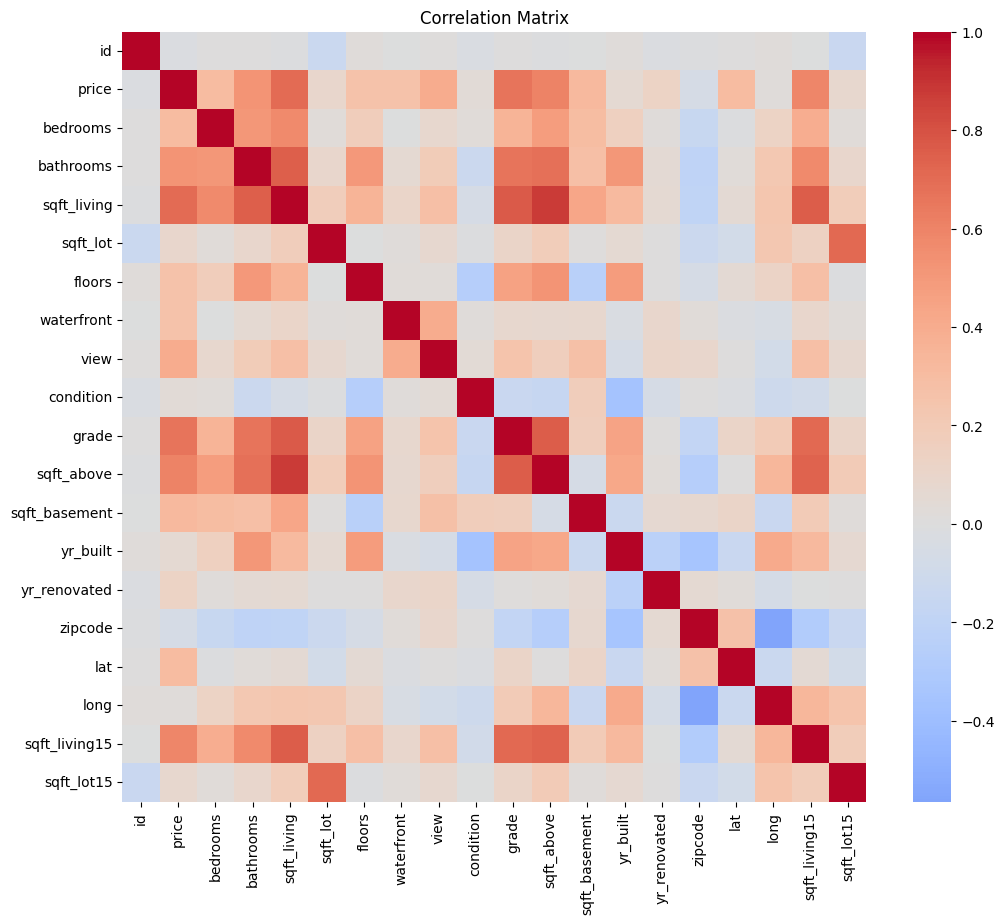


Top correlations with 'price':
price            1.000000
sqft_living      0.702035
grade            0.667434
sqft_above       0.605567
sqft_living15    0.585379
bathrooms        0.525138
view             0.397293
sqft_basement    0.323816
bedrooms         0.308350
lat              0.307003
waterfront       0.266369
Name: price, dtype: float64


In [14]:
# plotting correlation matrix
plt.figure(figsize=(12,10))
corr = df_raw.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0, annot=False)
plt.title("Correlation Matrix")
plt.show()

# show top 10 correlations with target (price)
print("\nTop correlations with 'price':")
print(corr['price'].abs().sort_values(ascending=False).head(11))

In [15]:
'''
Compute and see which numeric columns are highly skewed.
'''
# get numeric columns
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns

# compute skewness for each numeric column
skewness = df_raw[numeric_cols].skew().sort_values(ascending=False)

# view only highly skewed columns
skewness[abs(skewness) > 0.75]

sqft_lot         13.060019
waterfront       11.385108
sqft_lot15        9.506743
yr_renovated      4.549493
price             4.024069
view              3.395750
bedrooms          1.974300
sqft_basement     1.577965
sqft_living       1.471555
sqft_above        1.446664
sqft_living15     1.108181
condition         1.032805
long              0.885053
grade             0.771103
dtype: float64

## Data Preprocessing and Feature Engineering:

Steps for pre-processing:
1. Drop rows with 0 bedrooms and 0 bathrooms
2. Drop the row which has 33 bedrooms
3. Keep cleaned dataset as 'df_clean'

Steps for feature engineering:
1. Find 'transaction_month' using 'date'
2. Find 'house_age' using 'date' and 'yr_built'
3. Add 'renovated_flag' (0,1) to know if house was renovated or not
4. Drop 'id' and 'date' and any new columns made to calculate 'house_age'
5. Drop 'zipcode' since clustering by 'lat' & 'long' will be used later
6. Drop 'yr_renovated' since 'renovated_flag' is created
7. Drop 'sqft_above' since it is redundant with 'sqft_living' (above = living - basement)
8. Log-transform selected skewed numeric columns:
    ['price', 'sqft_lot', 'sqft_living', 'sqft_basement', 'sqft_living15',
    'sqft_lot15']



In [16]:
# Pre-processing

# 1. Remove rows where bedrooms or bathrooms are 0 - droppin invalid rows
df = df[(df["bedrooms"] > 0) & (df["bathrooms"] > 0)]

# 2. Remove specific row(s) where bedrooms == 33 - dropping invalid row
df = df[df["bedrooms"] != 33]

# 3. Create cleaned dataset (no feature eng, data cleaned)
df_clean = df.copy()

In [17]:
# In case feature engineering needs to be run again
# df = df_clean

In [18]:
# Feature Engineering

# 1. Extract transaction_month from date - used as temporal feature
df['transaction_month'] = pd.to_datetime(df['date']).dt.month

# 2. Extract transaction year from 'date'
df['transaction_year'] = pd.to_datetime(df['date']).dt.year

# 2. Compute house age - new feature
df['house_age'] = df['transaction_year'] - df['yr_built']

# 3. Create 'renovated_flag' (value = 0 or 1) - compute new feature
df['renovated_flag'] = (df['yr_renovated'] > 0).astype(int)

# 4. Create 'basement_flag' (value = 0 or 1) - compute new feature
df['basement_flag'] = (df['sqft_basement'] > 0).astype(int)

# 5. Create 'month_sin' and 'month_cos' to capture cyclic features
df['month_sin'] = np.sin(2 * np.pi * df['transaction_month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['transaction_month'] / 12)

# 5-8. Drop 'id', 'date', 'transaction_year', 'yr_built', 'zipcode',
# 'yr_renovated', 'sqft_above', 'transaction_month' - removing redundant columns
df = df.drop(columns=['id', 'date', 'transaction_year', 'yr_built', 'zipcode',
                      'yr_renovated', 'sqft_above', 'transaction_month'],
             errors="ignore")

# 9. log-transform selected skewed numeric columns
skewed_cols = ['price', 'sqft_lot', 'sqft_living', 'sqft_basement',
               'sqft_living15', 'sqft_lot15']
for col in skewed_cols:
    if col in df.columns:
        df[col] = np.log1p(df[col])

print("Columns after dropping redundant ones:\n", df.columns.tolist())
print("Log transformation applied to:\n", skewed_cols)

Columns after dropping redundant ones:
 ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'house_age', 'renovated_flag', 'basement_flag', 'month_sin', 'month_cos']
Log transformation applied to:
 ['price', 'sqft_lot', 'sqft_living', 'sqft_basement', 'sqft_living15', 'sqft_lot15']


In [19]:
# check stats of df again
df.describe()

price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  21596.000000  21596.000000  21596.000000  21596.000000  21596.000000   
mean      13.048130      3.371828      2.115843      7.551303      8.989996   
std        0.526424      0.904114      0.768998      0.423955      0.901959   
min       11.264477      1.000000      0.500000      5.916202      6.255750   
25%       12.682310      3.000000      1.750000      7.266129      8.525360   
50%       13.017005      3.000000      2.250000      7.555382      8.938532   
75%       13.377007      4.000000      2.500000      7.844241      9.276737   
max       15.856731     11.000000      8.000000      9.513477     14.317110   

             floors    waterfront          view     condition         grade  \
count  21596.000000  21596.000000  21596.000000  21596.000000  21596.000000   
mean       1.494119      0.007548      0.234303      3.409752      7.657946   
std        0.539685      0.086551      0.766406      0.650471      1.173218   
min        1.000000      0.000000      0.000000      1.000000      3.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

       sqft_basement           lat          long  sqft_living15    sqft_lot15  \
count   21596.000000  21596.000000  21596.000000   21596.000000  21596.000000   
mean        2.530989     47.560087   -122.213977       7.540070      8.960953   
std         3.171015      0.138552      0.140725       0.327290      0.812503   
min         0.000000     47.155900   -122.519000       5.991465      6.480045   
25%         0.000000     47.471100   -122.328000       7.307202      8.537192   
50%         0.000000     47.571800   -122.231000       7.518064      8.938663   
75%         6.329721     47.678000   -122.125000       7.766841      9.218705   
max         8.480737     47.777600   -121.315000       8.734077     13.677628   

          house_age  renovated_flag  basement_flag     month_sin     month_cos  
count  21596.000000    21596.000000   21596.000000  2.159600e+04  21596.000000  
mean      43.322189        0.042323       0.392943 -1.405735e-02     -0.146678  
std       29.377523        0.201329       0.488416  7.092477e-01      0.689421  
min       -1.000000        0.000000       0.000000 -1.000000e+00     -1.000000  
25%       18.000000        0.000000       0.000000 -8.660254e-01     -0.866025  
50%       40.000000        0.000000       0.000000  1.224647e-16     -0.500000  
75%       63.000000        0.000000       1.000000  5.000000e-01      0.500000  
max      115.000000        1.000000       1.000000  1.000000e+00      1.000000

In [20]:
# check first 5 rows of df
df.head(5)

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  12.309987         3       1.00     7.074117  8.639588     1.0           0   
1  13.195616         3       2.25     7.852050  8.887791     2.0           0   
2  12.100718         2       1.00     6.647688  9.210440     1.0           0   
3  13.311331         4       3.00     7.581210  8.517393     1.0           0   
4  13.142168         3       2.00     7.427144  8.997271     1.0           0   

   view  condition  grade  sqft_basement      lat     long  sqft_living15  \
0     0          3      7       0.000000  47.5112 -122.257       7.201171   
1     0          3      7       5.993961  47.7210 -122.319       7.433075   
2     0          3      6       0.000000  47.7379 -122.233       7.908755   
3     0          5      7       6.814543  47.5208 -122.393       7.215975   
4     0          3      8       0.000000  47.6168 -122.045       7.496097   

   sqft_lot15  house_age  renovated_flag  basement_flag     month_sin  \
0    8.639588         59               0              0 -8.660254e-01   
1    8.941153         63               1              1 -2.449294e-16   
2    8.995041         82               0              0  8.660254e-01   
3    8.517393         49               0              1 -2.449294e-16   
4    8.923191         28               0              0  8.660254e-01   

   month_cos  
0        0.5  
1        1.0  
2        0.5  
3        1.0  
4        0.5

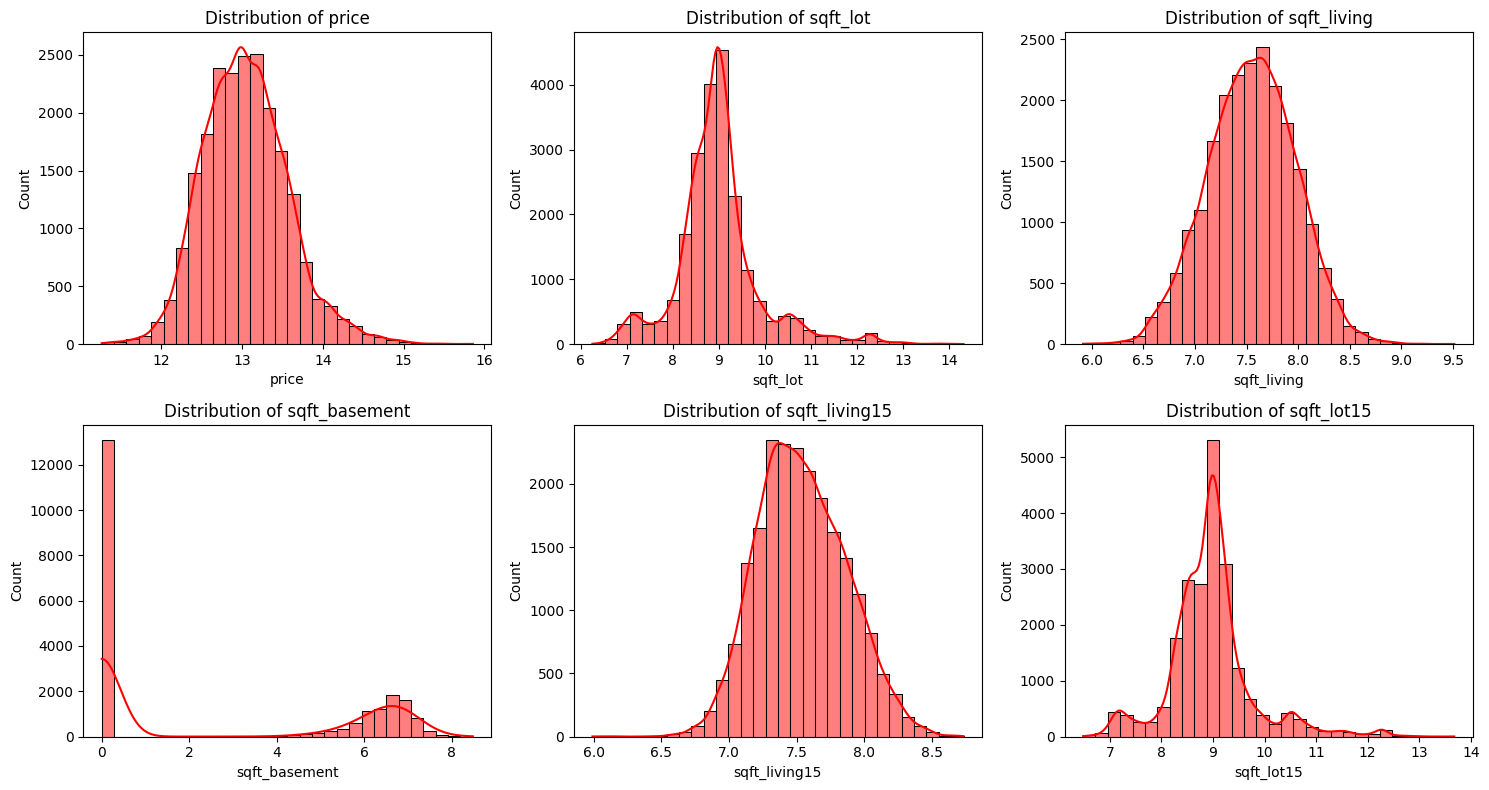

In [21]:
# Plot histograms to visualise distribution of log-transformed columns
# to check if it reduced skewness
n_cols = 3
n_rows = int(np.ceil(len(skewed_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(skewed_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color='red')
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
plt.tight_layout()
plt.show()

Descriptive statistics for sqft_living after log transformation:
count    21596.000000
mean         7.551303
std          0.423955
min          5.916202
25%          7.266129
50%          7.555382
75%          7.844241
max          9.513477
Name: sqft_living, dtype: float64

Quantile thresholds for sqft_living after log transformation:
0.25    7.266129
0.50    7.555382
0.75    7.844241
Name: sqft_living, dtype: float64


<Figure size 1200x500 with 0 Axes>

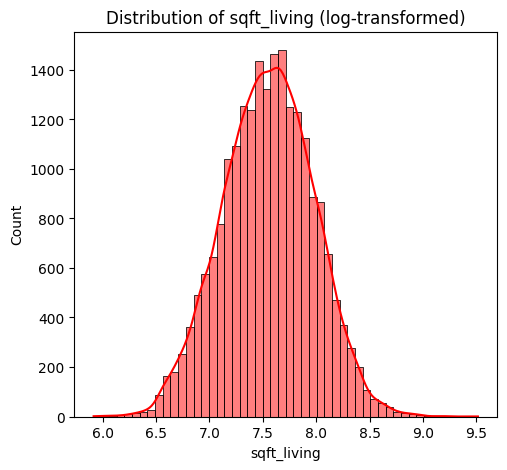

In [22]:
print("Descriptive statistics for sqft_living after log transformation:")
print(df["sqft_living"].describe())

plt.figure(figsize=(12,5))

# without log transformation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df["sqft_living"], bins=50, kde=True, color="red")
plt.title("Distribution of sqft_living (log-transformed)")
plt.xlabel("sqft_living")
plt.ylabel("Count")

print("\nQuantile thresholds for sqft_living after log transformation:")
print(df["sqft_living"].quantile([0.25, 0.5, 0.75]))

## K-means Clustering using 'lat' and 'long' features

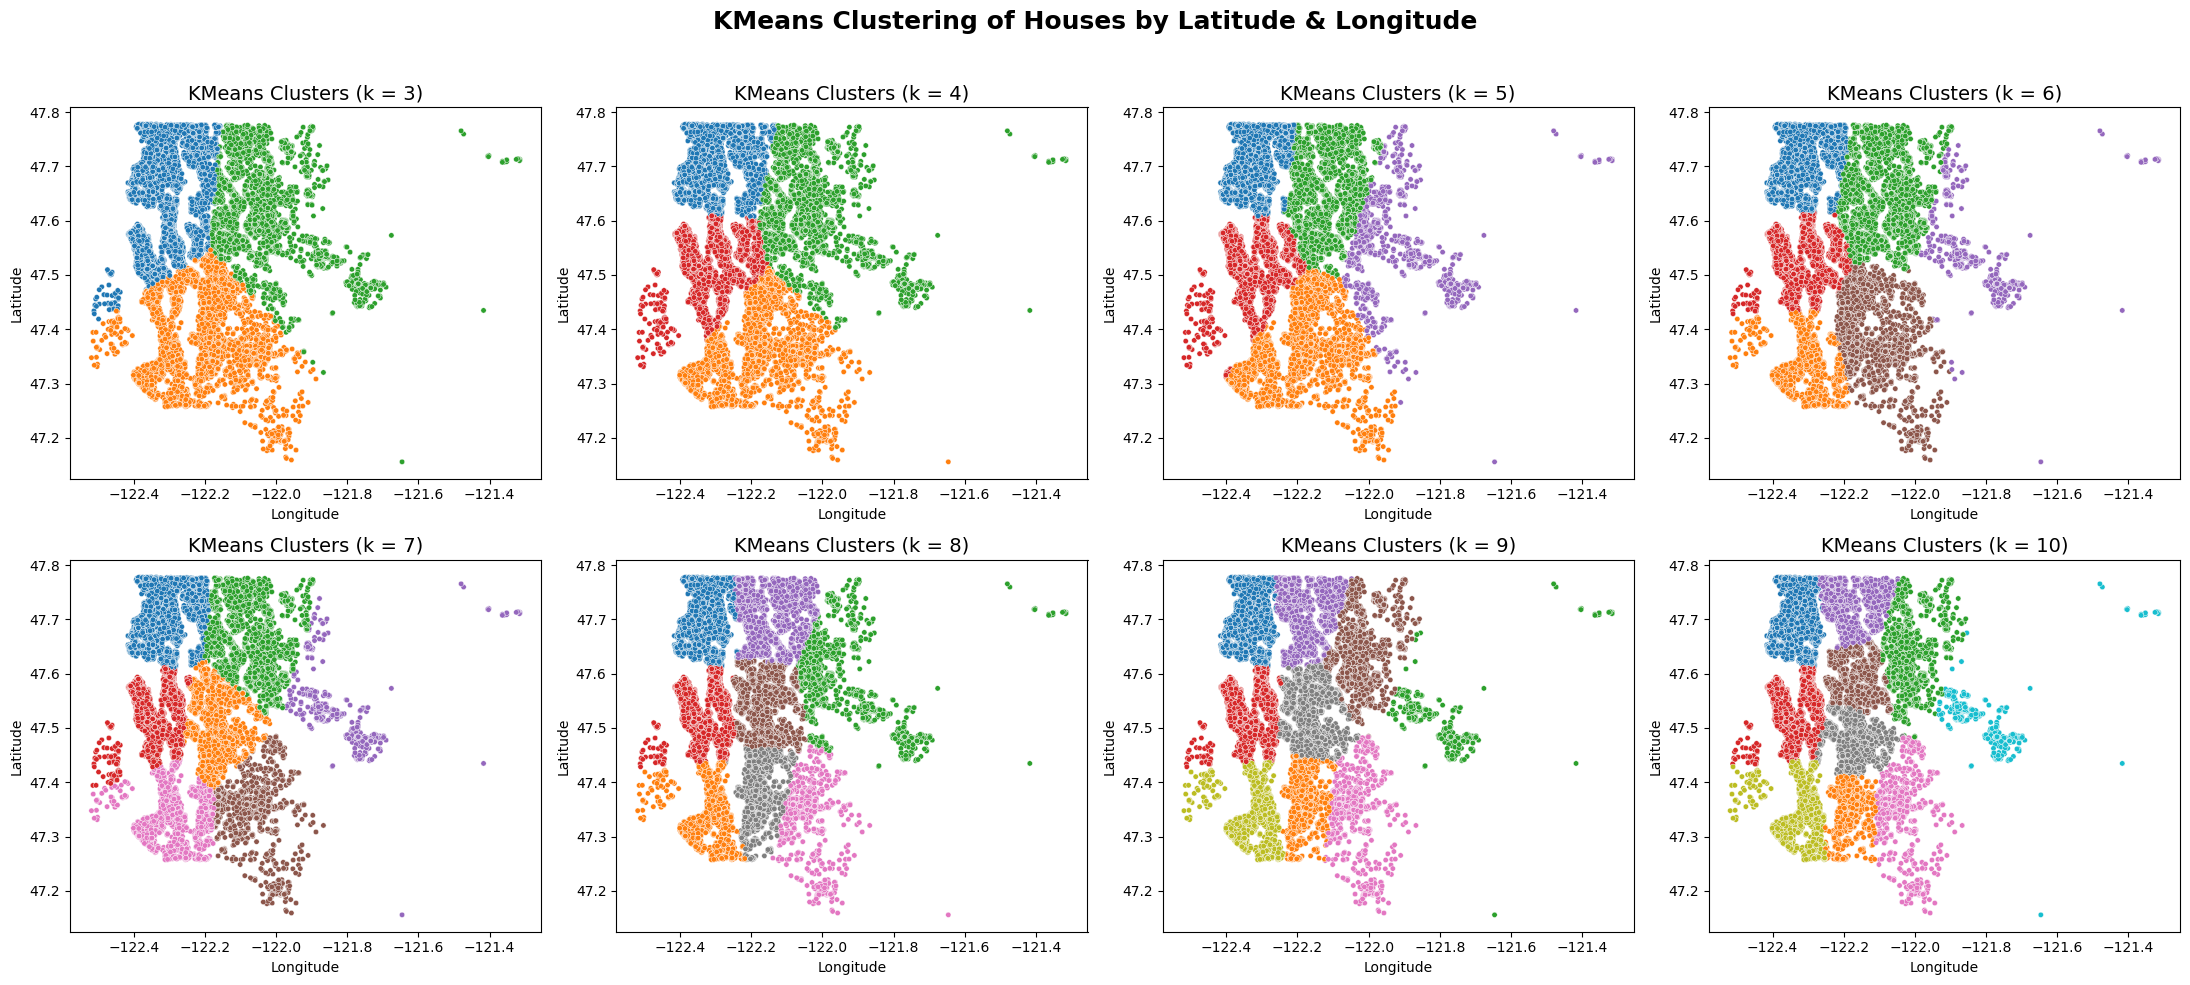

In [23]:
# create region clusters using kmeans clustering for 'lat' and 'long' features
# also used for MTL partitioning

X = df[['lat', 'long']]

# range of k values to visualize
candidate_ks = [3, 4, 5, 6, 7, 8, 9, 10]

fig, axes = plt.subplots(2, 4, figsize=(22, 10))
axes = axes.flatten()

# spatial scatter plot for each k value
for i, k in enumerate(candidate_ks):
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(X)

    sns.scatterplot(
        x='long', y='lat',
        hue=clusters,
        data=df,
        palette='tab10',
        s=15,
        ax=axes[i],
        legend=False
    )

    axes[i].set_title(f"KMeans Clusters (k = {k})", fontsize=14)
    axes[i].set_xlabel("Longitude")
    axes[i].set_ylabel("Latitude")

plt.suptitle("KMeans Clustering of Houses by Latitude & Longitude", fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

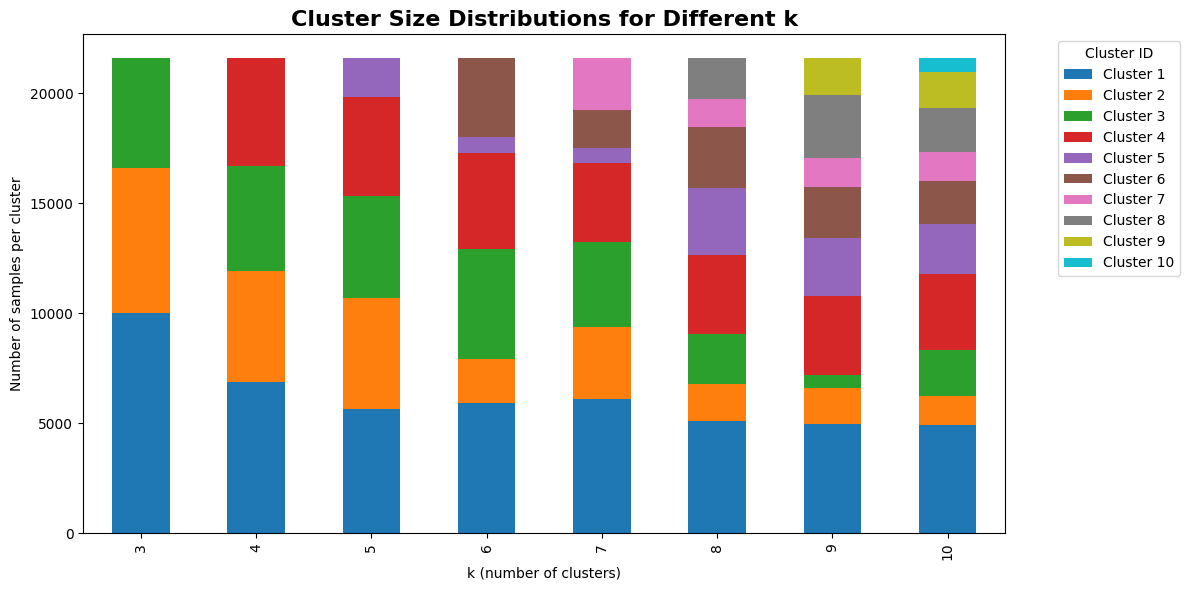

In [24]:
# cluster size distributions
cluster_distributions = {}

for k in candidate_ks:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    counts = pd.Series(labels).value_counts().sort_index()
    cluster_distributions[k] = counts

dist_df = pd.DataFrame(cluster_distributions).fillna(0)
dist_df.index = [f"Cluster {i+1}" for i in range(dist_df.shape[0])]
dist_df = dist_df.T  # rows = k, columns = cluster IDs

dist_df.plot(kind='bar', stacked=True, colormap='tab10', figsize=(12,6))
plt.title("Cluster Size Distributions for Different k", fontsize=16, fontweight='bold')
plt.xlabel("k (number of clusters)")
plt.ylabel("Number of samples per cluster")
plt.legend(title="Cluster ID", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Create 'region_cluster'

In [25]:
# using k=4 (more "even" distribution compared to k=3 and k=5)

kmeans_final = KMeans(n_clusters=4, random_state=42)
df['region_cluster'] = kmeans_final.fit_predict(df[['lat', 'long']])

# ensures that unique values of the feature start from 1
df['region_cluster'] = df['region_cluster'] + 1

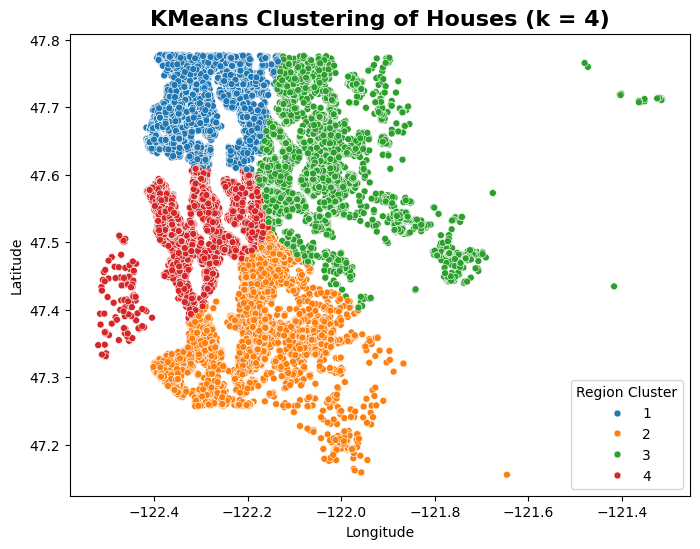

region_cluster
1    6869
2    5041
3    4774
4    4912
Name: count, dtype: int64



In [26]:
# plot the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='long', y='lat',
    hue='region_cluster',
    data=df,
    palette='tab10',
    s=25
)
plt.title("KMeans Clustering of Houses (k = 4)", fontsize=16, fontweight='bold')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Region Cluster")
plt.show()

# inspect cluster distribution
print(df['region_cluster'].value_counts().sort_index())
print()

In [27]:
# create unscaled dataset
df_unscaled = df.copy()

# check first 5 rows of current dataset
df.head(5)

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  12.309987         3       1.00     7.074117  8.639588     1.0           0   
1  13.195616         3       2.25     7.852050  8.887791     2.0           0   
2  12.100718         2       1.00     6.647688  9.210440     1.0           0   
3  13.311331         4       3.00     7.581210  8.517393     1.0           0   
4  13.142168         3       2.00     7.427144  8.997271     1.0           0   

   view  condition  grade  ...      lat     long  sqft_living15  sqft_lot15  \
0     0          3      7  ...  47.5112 -122.257       7.201171    8.639588   
1     0          3      7  ...  47.7210 -122.319       7.433075    8.941153   
2     0          3      6  ...  47.7379 -122.233       7.908755    8.995041   
3     0          5      7  ...  47.5208 -122.393       7.215975    8.517393   
4     0          3      8  ...  47.6168 -122.045       7.496097    8.923191   

   house_age  renovated_flag  basement_flag     month_sin  month_cos  \
0         59               0              0 -8.660254e-01        0.5   
1         63               1              1 -2.449294e-16        1.0   
2         82               0              0  8.660254e-01        0.5   
3         49               0              1 -2.449294e-16        1.0   
4         28               0              0  8.660254e-01        0.5   

   region_cluster  
0               4  
1               1  
2               1  
3               4  
4               3  

[5 rows x 21 columns]

## Binning sqft_living into 4 and 2 bins to create task IDs for MTL

In [28]:
# Ensure consistent row order
df = df.sort_values(by=['lat','long','price']).reset_index(drop=True)

# Create 4-bin sqft_living bins on FULL dataset (not train only)
bin_maker_4 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
sqft_bin4_full = bin_maker_4.fit_transform(df[['sqft_living']]).astype(int).ravel()
bin_labels_4 = ["small","medium","large","very_large"]
df['sqft_living_bin_4'] = pd.Categorical.from_codes(sqft_bin4_full, bin_labels_4)

# Create 16-task grouping for visualization/report
df['task_id_num_16'] = (df['region_cluster'] - 1) * 4 + sqft_bin4_full

# Create human-readable labels for the 16 tasks
df['task_id_str_16'] = (
    "region_"
    + df['region_cluster'].astype(str)
    + "_"
    + df['sqft_living_bin_4'].astype(str)
)

# Collapse to 2 bins (stable grouping for MTL)
collapse_map = {
    "small":"small_medium",
    "medium":"small_medium",
    "large":"large_vlarge",
    "very_large":"large_vlarge"
}
df['sqft_living_bin_2'] = df['sqft_living_bin_4'].map(collapse_map)

bin_label_to_int = {"small_medium":0,"large_vlarge":1}
sqft_bin2_full = df['sqft_living_bin_2'].map(bin_label_to_int).values

# Create 8-task grouping for visualisation and usage before splitting
df['task_id_num_8'] = (df['region_cluster'] - 1) * 2 + sqft_bin2_full

# Create human-readable labels for the 8 tasks
df['task_id_str_8'] = (
    "region_"
    + df['region_cluster'].astype(str)
    + "_"
    + df['sqft_living_bin_2'].astype(str)
)

In [29]:
# Classification of columns in dataset

# Target column
target_col = ['price']

# Columns to scale (continuous + ordinal)
continuous_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
    'condition', 'grade', 'sqft_basement', 'sqft_living15',
    'sqft_lot15', 'house_age'
]

# do NOT scale these as they are in binary already
binary_cols = ['waterfront', 'renovated_flag', 'basement_flag']

# do NOT scale since they are spatial coordinates
location_cols = ['lat', 'long']

# do NOT scale since they are cyclical encoded
cyclic_cols = ['month_sin', 'month_cos']

# strictly for MTL task definition
partition_cols = ['region_cluster']

In [30]:
# Ensure consistent row order
df = df.sort_values(by=['lat','long','price']).reset_index(drop=True)

# Create 4-bin sqft_living bins on FULL dataset (not train only)
bin_maker_4 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
sqft_bin4_full = bin_maker_4.fit_transform(df[['sqft_living']]).astype(int).ravel()
bin_labels_4 = ["small","medium","large","very_large"]
df['sqft_living_bin_4'] = pd.Categorical.from_codes(sqft_bin4_full, bin_labels_4)

# Create 16-task grouping for visualization/report
df['task_id_num_16'] = (df['region_cluster'] - 1) * 4 + sqft_bin4_full

# Create human-readable labels for the 16 tasks
df['task_id_str_16'] = (
    "region_"
    + df['region_cluster'].astype(str)
    + "_"
    + df['sqft_living_bin_4'].astype(str)
)

# Collapse to 2 bins (stable grouping for MTL)
collapse_map = {
    "small":"small_medium",
    "medium":"small_medium",
    "large":"large_vlarge",
    "very_large":"large_vlarge"
}
df['sqft_living_bin_2'] = df['sqft_living_bin_4'].map(collapse_map)

bin_label_to_int = {"small_medium":0,"large_vlarge":1}
sqft_bin2_full = df['sqft_living_bin_2'].map(bin_label_to_int).values

# Create 8-task grouping for visualisation and usage before splitting
df['task_id_num_8'] = (df['region_cluster'] - 1) * 2 + sqft_bin2_full

# Create human-readable labels for the 8 tasks
df['task_id_str_8'] = (
    "region_"
    + df['region_cluster'].astype(str)
    + "_"
    + df['sqft_living_bin_2'].astype(str)
)

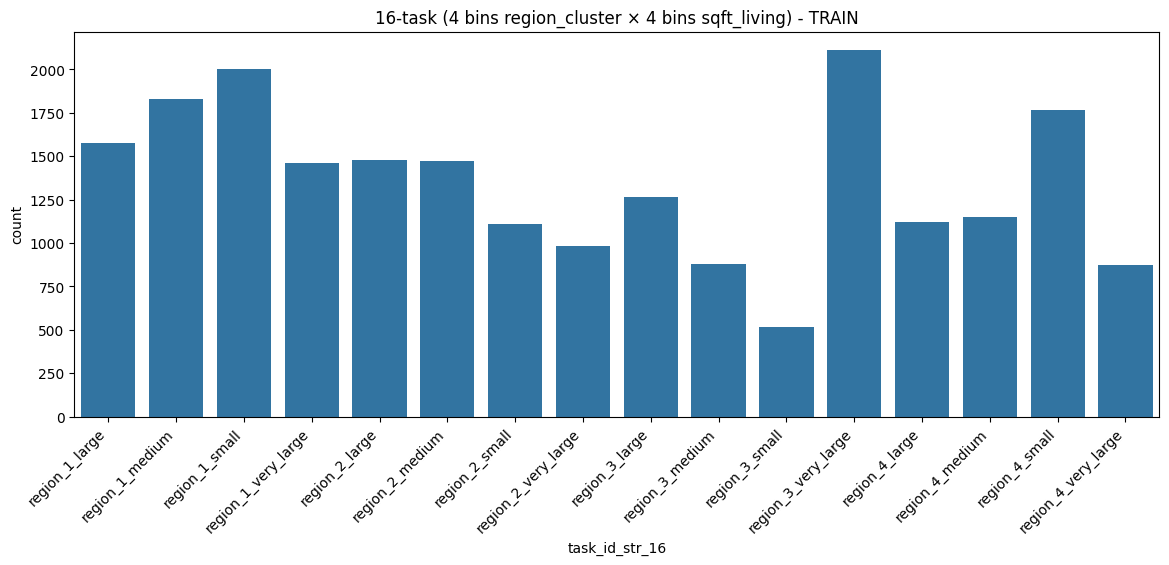


16-task distribution (4 bins region_cluster × 4 bins sqft_living) - TRAIN
task_id_str_16
region_1_large         1577
region_1_medium        1827
region_1_small         2004
region_1_very_large    1461
region_2_large         1476
region_2_medium        1472
region_2_small         1111
region_2_very_large     982
region_3_large         1264
region_3_medium         880
region_3_small          518
region_3_very_large    2112
region_4_large         1122
region_4_medium        1150
region_4_small         1764
region_4_very_large     876
Name: count, dtype: int64


In [31]:
# Plot and confirm distributions for 16-tasks
plt.figure(figsize=(14,5))
sns.countplot(x="task_id_str_16", data=df,
              order=sorted(df["task_id_str_16"].unique()))
plt.xticks(rotation=45, ha='right')
plt.title("16-task (4 bins region_cluster × 4 bins sqft_living) - TRAIN")
plt.show()

print("\n16-task distribution (4 bins region_cluster × 4 bins sqft_living) - TRAIN")
print(df["task_id_str_16"].value_counts().sort_index())

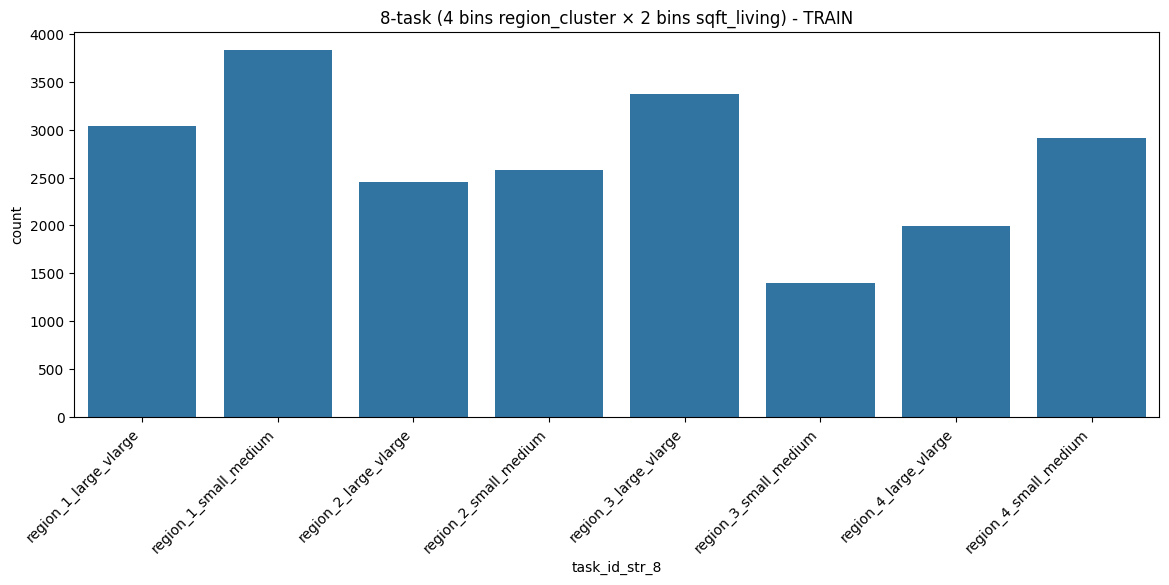


### 8-task distribution 4 bins region_cluster × 2 bins sqft_living) - TRAIN
task_id_str_8
region_1_large_vlarge    3038
region_1_small_medium    3831
region_2_large_vlarge    2458
region_2_small_medium    2583
region_3_large_vlarge    3376
region_3_small_medium    1398
region_4_large_vlarge    1998
region_4_small_medium    2914
Name: count, dtype: int64


In [32]:
# Plot and confirm distributions for 8-tasks

plt.figure(figsize=(14,5))
sns.countplot(x="task_id_str_8", data=df, order=sorted(df["task_id_str_8"].unique()))
plt.xticks(rotation=45, ha='right')
plt.title("8-task (4 bins region_cluster × 2 bins sqft_living) - TRAIN")
plt.show()

print("\n### 8-task distribution 4 bins region_cluster × 2 bins sqft_living) - TRAIN")
print(df["task_id_str_8"].value_counts().sort_index())

## Train-test split (70/30)

In [33]:
# Train-test split stratified by task_id
X = df.drop(columns=[
    'price',
    'task_id_num_8',
    'sqft_living_bin_4',
    'sqft_living_bin_2',
    'task_id_str_8',
    'task_id_num_16',
    'task_id_str_16'
], errors='ignore')
y = df['price']
task = df['task_id_num_8']

X_train, X_test, y_train, y_test, task_train, task_test = train_test_split(
    X, y, task,
    test_size=0.3,
    random_state=42,
    stratify=task
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Unique tasks (train):", np.unique(task_train))
print("Unique tasks (test):", np.unique(task_test))

Train: (15117, 20) Test: (6479, 20)
Unique tasks (train): [0 1 2 3 4 5 6 7]
Unique tasks (test): [0 1 2 3 4 5 6 7]


## Scaling continuous numeric features in train and test sets only for Ridge & MTL

In [34]:
# Scaling (fit only on train, apply to both)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler_X = StandardScaler()
X_train_scaled[continuous_cols] = scaler_X.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols]  = scaler_X.transform(X_test[continuous_cols])

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).ravel()

## Create copies of dataset for all models

In [35]:
# for STL ridge regression (scaled)
X_train_ridge, X_test_ridge = X_train_scaled.copy(), X_test_scaled.copy()
y_train_ridge, y_test_ridge = y_train_scaled.copy(), y_test_scaled.copy()

In [36]:
# for STL random forest (unscaled)
X_train_rf, X_test_rf = X_train.copy(), X_test.copy()
y_train_rf, y_test_rf = y_train.copy(), y_test.copy()

In [37]:
# for MTL L2,1 regression (scaled + partitioning)
X_train_mtl, X_test_mtl = X_train_scaled.copy(), X_test_scaled.copy()
y_train_mtl, y_test_mtl = y_train_scaled.copy(), y_test_scaled.copy()
task_train_mtl, task_test_mtl = task_train.copy(), task_test.copy()

In [38]:
# Sanity check
print("Ridge:", X_train_ridge.shape, X_test_ridge.shape)
print("RF:", X_train_rf.shape, X_test_rf.shape)
print("MTL:", X_train_mtl.shape, X_test_mtl.shape)
print("Unique tasks in train:", np.unique(task_train_mtl).size)
print("Unique tasks in test:", np.unique(task_test_mtl).size)

Ridge: (15117, 20) (6479, 20)
RF: (15117, 20) (6479, 20)
MTL: (15117, 20) (6479, 20)
Unique tasks in train: 8
Unique tasks in test: 8


# **Training and evaluating the 3 baseline models:**

Metrics for model evaluation (after training) *should be done within each section per model*:
1. RMSE - root mean squared error
2. MAE - mean absolute error
3. R²

#**Ridge Regression Model**


## Model Training (Ridge)




In [39]:
# Ridge Regression Model

# Initialize and train the Ridge model
ridge_model = Ridge(alpha=1.0)  # You can tune the alpha parameter
ridge_model.fit(X_train_ridge, y_train_ridge)

Ridge()

## Evaluation

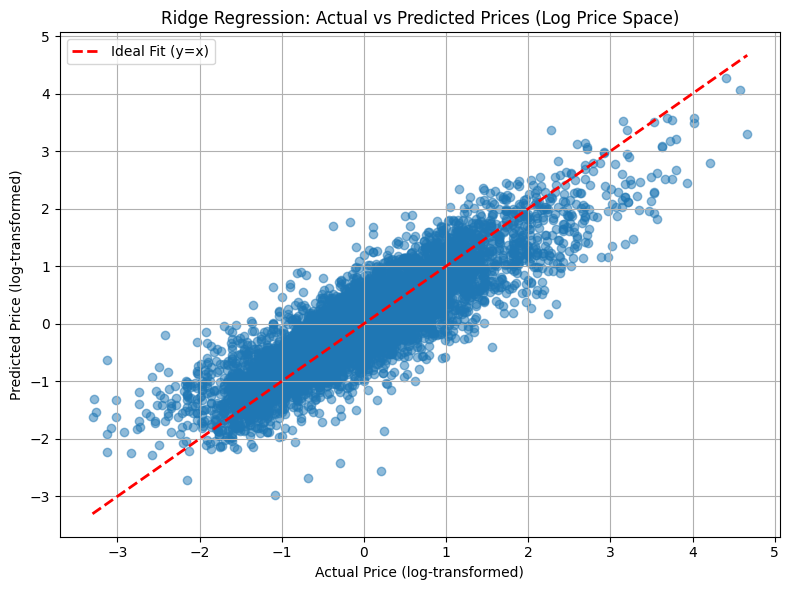


Ridge Regression Model Evaluation (Log Price Space):
R²   : 0.7630
RMSE : 0.4935
MAE  : 0.3771


In [40]:
# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test_ridge)

# Evaluate the model
rmse_ridge = np.sqrt(mean_squared_error(y_test_ridge, y_pred_ridge))
mae_ridge = mean_absolute_error(y_test_ridge, y_pred_ridge)
r2_ridge = r2_score(y_test_ridge, y_pred_ridge)

# plot Ridge Regression actual vs predicted log price
plt.figure(figsize=(8,6))
plt.scatter(y_test_ridge, y_pred_ridge, alpha=0.5)
plt.plot([y_test_ridge.min(), y_test_ridge.max()],
         [y_test_ridge.min(), y_test_ridge.max()],
         'r--', lw=2, label="Ideal Fit (y=x)")
plt.xlabel("Actual Price (log-transformed)")
plt.ylabel("Predicted Price (log-transformed)")
plt.title("Ridge Regression: Actual vs Predicted Prices (Log Price Space)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRidge Regression Model Evaluation (Log Price Space):")
print(f"R²   : {r2_ridge:.4f}")
print(f"RMSE : {rmse_ridge:,.4f}")
print(f"MAE  : {mae_ridge:,.4f}")

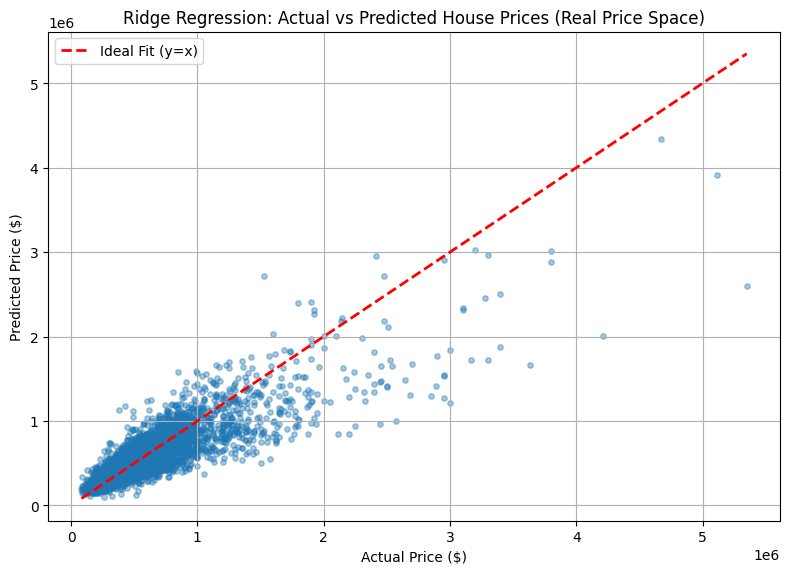


Ridge Regression Performance (Real Price Space)
R²   : 0.7345
RMSE : 190,739
MAE  : 111,948


In [41]:
# Convert scaled log(price) -> unscaled log(price)
y_test_ridge_unscaled = scaler_y.inverse_transform(y_test_ridge.reshape(-1,1)).ravel()
y_pred_ridge_unscaled = scaler_y.inverse_transform(y_pred_ridge.reshape(-1,1)).ravel()

# Convert unscaled log(price) -> real price in $
y_true_ridge_price = np.expm1(y_test_ridge_unscaled)
y_pred_ridge_price = np.expm1(y_pred_ridge_unscaled)

# Evaluate in real price units
r2_ridge = r2_score(y_true_ridge_price, y_pred_ridge_price)
rmse_ridge = np.sqrt(mean_squared_error(y_true_ridge_price, y_pred_ridge_price))
mae_ridge = mean_absolute_error(y_true_ridge_price, y_pred_ridge_price)

# Plot Ridge Regression actual vs predicted true price
plt.figure(figsize=(8, 6))
plt.scatter(y_true_ridge_price, y_pred_ridge_price, alpha=0.4, s=15)
plt.plot(
    [y_true_ridge_price.min(), y_true_ridge_price.max()],
    [y_true_ridge_price.min(), y_true_ridge_price.max()],
    'r--', lw=2, label="Ideal Fit (y=x)"
)

plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Ridge Regression: Actual vs Predicted House Prices (Real Price Space)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRidge Regression Performance (Real Price Space)")
print(f"R²   : {r2_ridge:.4f}")
print(f"RMSE : {rmse_ridge:,.0f}")
print(f"MAE  : {mae_ridge:,.0f}")

# **Random Forest Model**

## Model Training (RF)

In [42]:
# Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=1,        # avoid parallel nondeterminism
)
rf_model.fit(X_train_rf, y_train_rf)

RandomForestRegressor(n_jobs=1, random_state=42)

## Evaluation

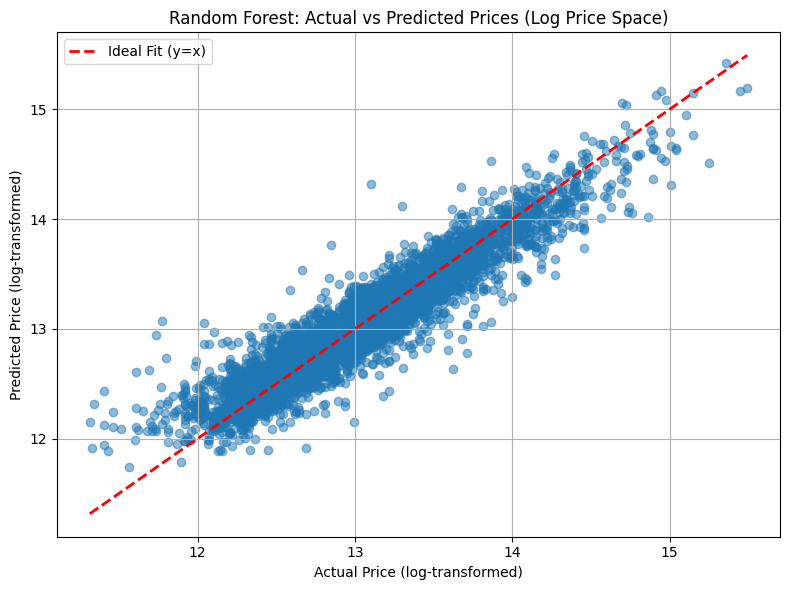


Random Forest Performance (Log Price Space)
R²   : 0.8893
RMSE : 0.1768
MAE  : 0.1239


In [43]:
# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test_rf)

# RF metrics in log space
r2_rf = r2_score(y_test_rf, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)

# plot RF log-price Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test_rf, y_pred_rf, alpha=0.5)
plt.plot([y_test_rf.min(), y_test_rf.max()],
         [y_test_rf.min(), y_test_rf.max()],
         'r--', lw=2, label="Ideal Fit (y=x)")
plt.xlabel("Actual Price (log-transformed)")
plt.ylabel("Predicted Price (log-transformed)")
plt.title("Random Forest: Actual vs Predicted Prices (Log Price Space)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRandom Forest Performance (Log Price Space)")
print(f"R²   : {r2_rf:.4f}")
print(f"RMSE : {rmse_rf:.4f}")
print(f"MAE  : {mae_rf:.4f}")

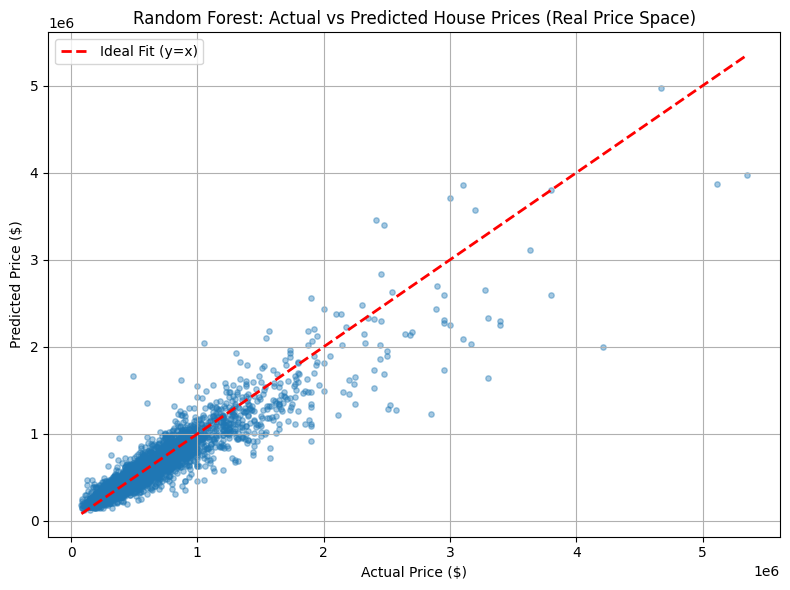


Random Forest Performance (Real Price Space)
R²   : 0.8721
RMSE : 132,398
MAE  : 70,032


In [44]:
# Convert RF predictions from log-scale to real price
y_true_rf_price = np.expm1(y_test_rf.values)
y_pred_rf_price = np.expm1(y_pred_rf)

# Evaluate in real price units
r2_rf = r2_score(y_true_rf_price, y_pred_rf_price)
rmse_rf = np.sqrt(mean_squared_error(y_true_rf_price, y_pred_rf_price))
mae_rf = mean_absolute_error(y_true_rf_price, y_pred_rf_price)

# Plot RF actual vs predicted true price
plt.figure(figsize=(8, 6))
plt.scatter(y_true_rf_price, y_pred_rf_price, alpha=0.4, s=15)
plt.plot(
    [y_true_rf_price.min(), y_true_rf_price.max()],
    [y_true_rf_price.min(), y_true_rf_price.max()],
    'r--', lw=2, label="Ideal Fit (y=x)"
)
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Random Forest: Actual vs Predicted House Prices (Real Price Space)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nRandom Forest Performance (Real Price Space)")
print(f"R²   : {r2_rf:.4f}")
print(f"RMSE : {rmse_rf:,.0f}")
print(f"MAE  : {mae_rf:,.0f}")

## **MTL L₂,₁ regression model**

## Model Training (MTL)



In [45]:
# Convert train/test data to Torch tensors
Xtr = torch.as_tensor(X_train_mtl.values, dtype=torch.float32)
Xte = torch.as_tensor(X_test_mtl.values, dtype=torch.float32)

ytr = torch.as_tensor(y_train_mtl.astype(np.float32))
yte = torch.as_tensor(y_test_mtl.astype(np.float32))

# Convert task IDs to numpy first
task_train_values = task_train_mtl.values.astype(int)
task_test_values  = task_test_mtl.values.astype(int)

ttr = torch.as_tensor(task_train_values, dtype=torch.long)
tte = torch.as_tensor(task_test_values, dtype=torch.long)

num_tasks = len(np.unique(task_train_values))
num_features = Xtr.shape[1]

print("Number of features:", num_features)
print("Number of tasks:", num_tasks)
print("Unique train tasks:", np.unique(task_train_values))

Number of features: 20
Number of tasks: 8
Unique train tasks: [0 1 2 3 4 5 6 7]


In [46]:
class LinearMTL(nn.Module):
    def __init__(self, D, T):
        super().__init__()
        # Deterministic initialization
        torch.manual_seed(42)
        self.W = nn.Parameter(torch.randn(D, T) * 0.01)

    def forward(self, X, task_id):
        W_sel = self.W[:, task_id]
        return (X.T * W_sel).sum(dim=0)

def l21_norm(W):
    return torch.norm(W, dim=1).sum()

# training function
def train_mtl(X, y, task_id, lambda_l21, steps=3000, lr=0.03, patience=250):
    model = LinearMTL(num_features, num_tasks)
    opt = optim.Adam([model.W], lr=lr, eps=1e-8)

    best_loss = float('inf')
    no_improve = 0

    for step in range(steps):
        opt.zero_grad()
        y_pred = model(X, task_id)

        loss = F.mse_loss(y_pred, y) + lambda_l21 * l21_norm(model.W)
        loss.backward()
        opt.step()

        if loss.item() < best_loss - 1e-7:
            best_loss = loss.item()
            best_W = model.W.data.clone()
            no_improve = 0
        else:
            no_improve += 1

        if no_improve >= patience:
            break

    model.W.data = best_W.clone()
    return model

# lambda cross validation
lambda_values = [1e-4, 5e-4, 1e-3]
kf = KFold(n_splits=5, shuffle=True, random_state=42)

val_scores = {}

for lam in lambda_values:
    fold_r2 = []

    for train_idx, val_idx in kf.split(X_train_mtl):
        Xtr_fold = torch.as_tensor(X_train_mtl.values[train_idx], dtype=torch.float32)
        ytr_fold = torch.as_tensor(y_train_mtl[train_idx].astype(np.float32))
        ttr_fold = torch.as_tensor(task_train_values[train_idx], dtype=torch.long)

        Xval_fold = torch.as_tensor(X_train_mtl.values[val_idx], dtype=torch.float32)
        yval_fold = torch.as_tensor(y_train_mtl[val_idx].astype(np.float32))
        tval_fold = torch.as_tensor(task_train_values[val_idx], dtype=torch.long)

        model = train_mtl(Xtr_fold, ytr_fold, ttr_fold, lambda_l21=lam, steps=2000, lr=0.03, patience=150)

        with torch.no_grad():
            pred_val = model(Xval_fold, tval_fold).cpu().numpy()

        fold_r2.append(r2_score(yval_fold.cpu().numpy(), pred_val))

    val_scores[lam] = np.mean(fold_r2)
    print(f"λ={lam:.1e} -> Mean CV R² = {val_scores[lam]:.4f}")

best_lambda = max(val_scores, key=val_scores.get)
print(f"\nBest λ selected: {best_lambda:.1e}")

# final model
mtl_model = train_mtl(Xtr, ytr, ttr, lambda_l21=best_lambda, steps=3500, lr=0.03, patience=250)

λ=1.0e-04 -> Mean CV R² = 0.8144
λ=5.0e-04 -> Mean CV R² = 0.8189
λ=1.0e-03 -> Mean CV R² = 0.8179

Best λ selected: 5.0e-04


## Evaluation

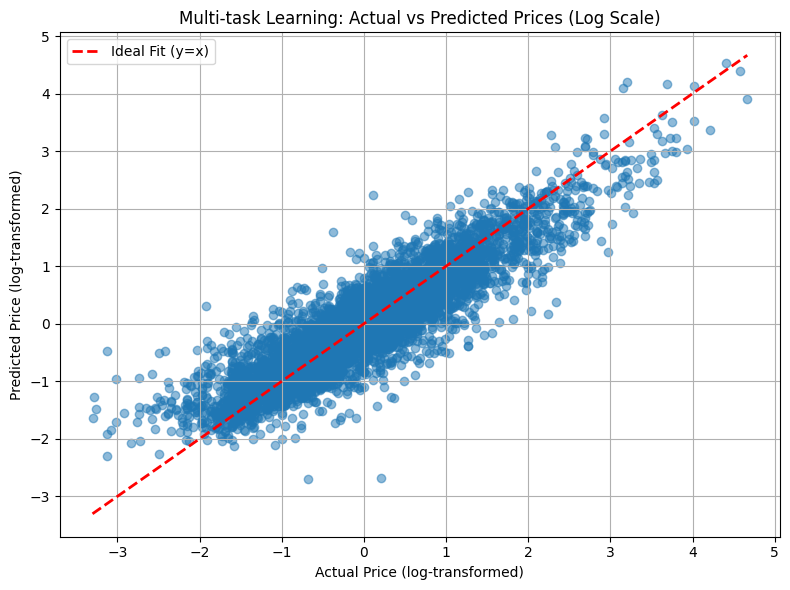


Multi-task Learning Model Performance (Log Price Scale):
R²: 0.8107
RMSE: 0.4411
MAE: 0.3270


In [47]:
# make predictions on test set
with torch.no_grad():
    y_pred_mtl = mtl_model(Xte, tte).cpu().numpy()

# find r2, rmse, mae of mtl
y_true_mtl = yte.cpu().numpy()
r2_mtl  = r2_score(y_true_mtl, y_pred_mtl)
rmse_mtl = np.sqrt(mean_squared_error(y_true_mtl, y_pred_mtl))
mae_mtl  = mean_absolute_error(y_true_mtl, y_pred_mtl)

# plot Multi-task Learning actual vs predicted log price
# shows model behaviour and training stability
plt.figure(figsize=(8,6))
plt.scatter(y_test_mtl, y_pred_mtl, alpha=0.5)
plt.plot([y_test_mtl.min(), y_test_mtl.max()],
          [y_test_mtl.min(), y_test_mtl.max()],
         'r--', lw=2, label="Ideal Fit (y=x)")
plt.xlabel("Actual Price (log-transformed)")
plt.ylabel("Predicted Price (log-transformed)")
plt.title("Multi-task Learning: Actual vs Predicted Prices (Log Scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMulti-task Learning Model Performance (Log Price Scale):")
print(f"R²: {r2_mtl:.4f}")
print(f"RMSE: {rmse_mtl:.4f}")
print(f"MAE: {mae_mtl:.4f}")

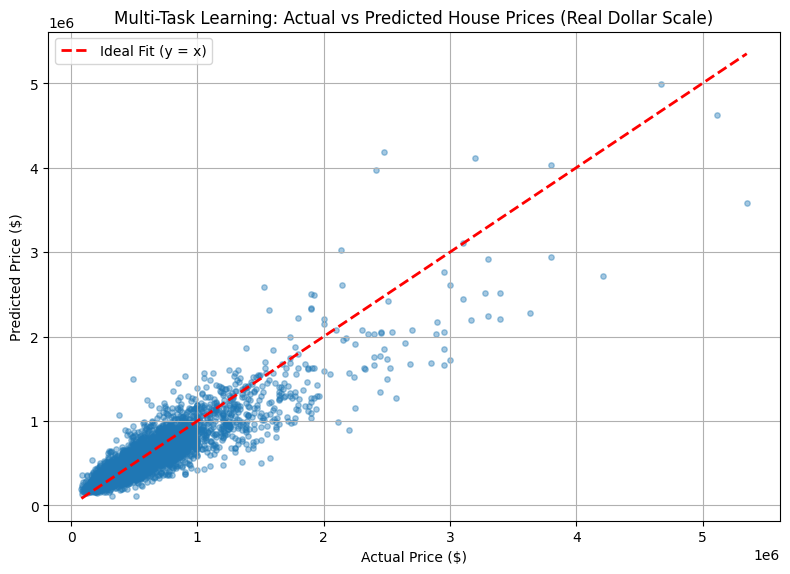


Multi-task Learning Model Performance (Real Price Scale):
R²: 0.8111
RMSE: 160,915
MAE: 95,423


In [48]:
# Convert scaled log(price) -> unscaled log(price)
y_true_mtl_unscaled = scaler_y.inverse_transform(yte.cpu().numpy().reshape(-1,1)).ravel()
y_pred_mtl_unscaled = scaler_y.inverse_transform(y_pred_mtl.reshape(-1,1)).ravel()

# Convert unscaled log(price) -> real price
y_true_mtl_price = np.expm1(y_true_mtl_unscaled)
y_pred_mtl_price = np.expm1(y_pred_mtl_unscaled)

r2_mtl= r2_score(y_true_mtl_price, y_pred_mtl_price)
rmse_mtl = np.sqrt(mean_squared_error(y_true_mtl_price, y_pred_mtl_price))
mae_mtl = mean_absolute_error(y_true_mtl_price, y_pred_mtl_price)

# Real price plot
# shows actual and predicted prices
plt.figure(figsize=(8, 6))
plt.scatter(y_true_mtl_price, y_pred_mtl_price, alpha=0.4, s=15)
plt.plot(
    [y_true_mtl_price.min(), y_true_mtl_price.max()],
    [y_true_mtl_price.min(), y_true_mtl_price.max()],
    'r--', lw=2, label="Ideal Fit (y = x)"
)

plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.title("Multi-Task Learning: Actual vs Predicted House Prices (Real Dollar Scale)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print("\nMulti-task Learning Model Performance (Real Price Scale):")
print(f"R²: {r2_mtl:.4f}")
print(f"RMSE: {rmse_mtl:,.0f}")
print(f"MAE: {mae_mtl:,.0f}")

In [49]:
# Define evaluation function
def evaluate_model(name, y_true_price, y_pred_price):
    r2   = r2_score(y_true_price, y_pred_price)
    rmse = np.sqrt(mean_squared_error(y_true_price, y_pred_price))
    mae  = mean_absolute_error(y_true_price, y_pred_price)

    print(f"\n{name} Performance (Real Price Units)")
    print(f"R²   : {r2:.4f}")
    print(f"RMSE : {rmse:,.0f}")
    print(f"MAE  : {mae:,.0f}")

    return [name, r2, rmse, mae]

# --- Evaluate each model using the *already computed* variables ---

ridge_results = evaluate_model("Ridge Regression",
                               y_true_ridge_price,
                               y_pred_ridge_price)

rf_results = evaluate_model("Random Forest",
                            y_true_rf_price,
                            y_pred_rf_price)

mtl_results = evaluate_model("MTL (L₂,₁)",
                             y_true_mtl_price,
                             y_pred_mtl_price)

# --- Final Comparison Table ---
comparison_df = pd.DataFrame(
    [ridge_results, rf_results, mtl_results],
    columns=["Model", "R²", "RMSE ($)", "MAE ($)"]
)

print("\n\n=== FINAL MODEL COMPARISON ===")
display(comparison_df.style.format({
    "R²": "{:.4f}",
    "RMSE ($)": "{:,.0f}",
    "MAE ($)": "{:,.0f}"
}))


Ridge Regression Performance (Real Price Units)
R²   : 0.7345
RMSE : 190,739
MAE  : 111,948

Random Forest Performance (Real Price Units)
R²   : 0.8721
RMSE : 132,398
MAE  : 70,032

MTL (L₂,₁) Performance (Real Price Units)
R²   : 0.8111
RMSE : 160,915
MAE  : 95,423


=== FINAL MODEL COMPARISON ===
